# End-to-End ML: Heart Disease UCI — MLOps-focused Notebook

**Objective:** Build, track, package, test, containerize, and prepare for production deployment a heart disease classifier using MLOps best practices.

This notebook covers:
- Data acquisition & EDA
- Cleaning & preprocessing pipeline
- Model training and cross-validated evaluation (Logistic Regression & Random Forest)
- Experiment tracking with MLflow
- Model packaging and reproducibility (pipeline + joblib + mlflow)
- Unit tests & CI workflow (GitHub Actions)
- Dockerfile & Kubernetes manifest for deployment
- Monitoring & logging basics

**Important**: Run cells sequentially. If running in Colab, upload the data or mount drive; this notebook assumes the CSV is located at `/mnt/data/heart_disease_uci.csv`.


### Theory
Install required packages for data science and MLOps tasks. We include mlflow for experiment tracking, joblib for model saving, fastapi/uvicorn for serving, and pytest for unit tests.




### Theory
We first load and inspect the dataset to understand schema, nulls, and target distribution. This informs cleaning and feature engineering choices.

We're reading `/mnt/data/heart_disease_uci.csv`.


In [2]:
import pandas as pd, numpy as np
path = "heart_disease_uci.csv"
df = pd.read_csv(path)
print("Shape:", df.shape)
display(df.head())
print("\nColumn dtypes and missing values:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nTarget (num) value counts:")
print(df['num'].value_counts())


Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



Column dtypes and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

Missing values per column:
id            0
age           0
sex           0
dataset      

### Theory
From the inspection:
- There are 920 rows and 16 columns (including `id` and `dataset`).
- The target is `num` with values 0,1,2,3,4. We'll convert to binary: 0 -> 0 (no disease), >0 -> 1 (disease).
- Many columns have missing values (trestbps, chol, fbs, thalch, exang, oldpeak, slope, ca, thal). We'll impute numeric columns with median and categorical with mode.
- Categorical features: sex, cp, restecg, slope, thal, dataset, etc.
- `id` is an identifier and can be dropped.

We will:
- Convert `num` to binary `target`.
- Drop `id`.
- Build a scikit-learn ColumnTransformer pipeline for preprocessing.


In [3]:
# Quick derived stats for EDA reports (to be used for plots later)
print("Columns:", list(df.columns))
print("Binary conversion plan: num==0 -> 0, else -> 1")


Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
Binary conversion plan: num==0 -> 0, else -> 1


### Theory
Generate EDA visualizations: histograms, correlation heatmap, class balance.
These help check for skewed features, collinearity, and class imbalance.

We save plots as artifacts for MLflow or report.


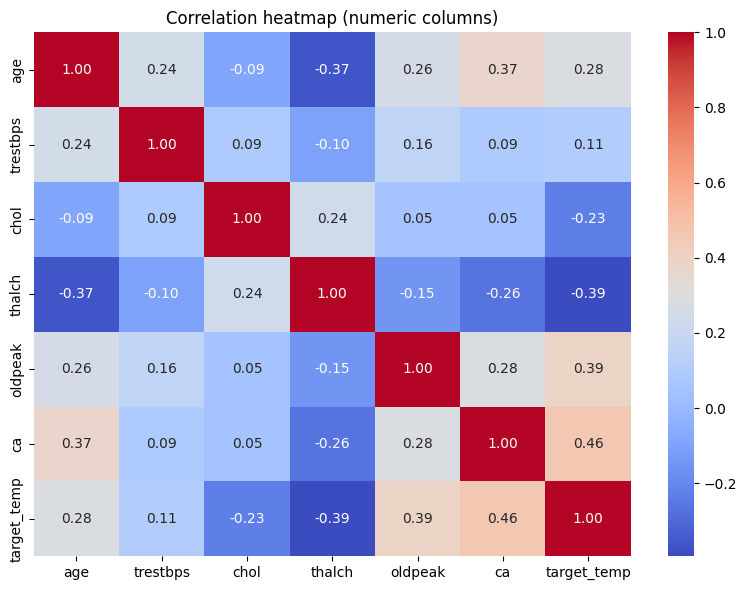

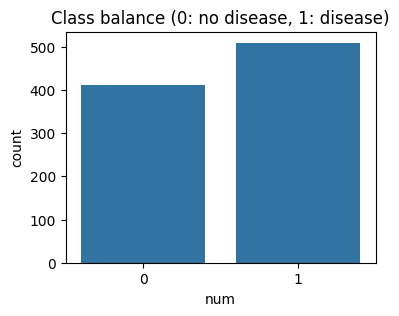

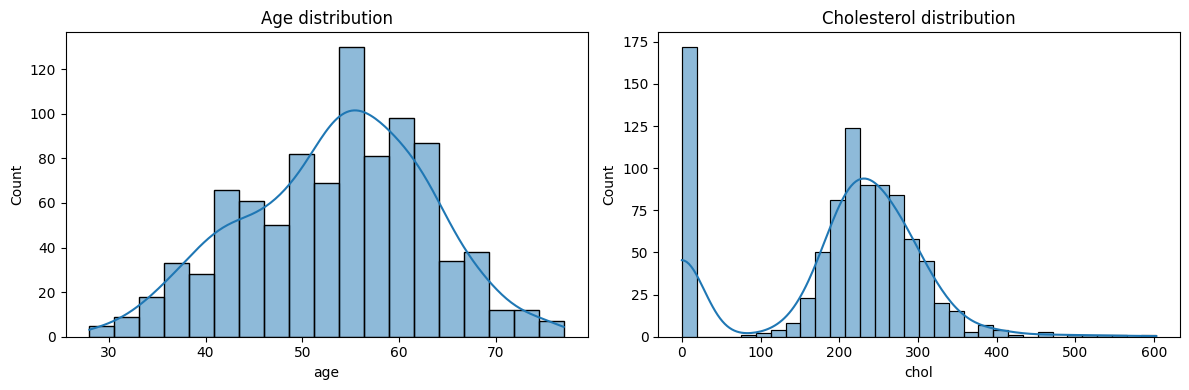

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Prepare a copy for plot-friendly numeric types
df_plot = df.copy()
# Convert booleans and categorical strings to numeric proxies for correlation plot (temporary)
df_plot['target_temp'] = (df_plot['num'] > 0).astype(int)
# Select numeric-ish columns for correlation
numeric_cols = ['age','trestbps','chol','thalch','oldpeak','ca','target_temp']
corr = df_plot[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation heatmap (numeric columns)")
plt.tight_layout()
plt.savefig("eda_correlation_heatmap.png")
plt.show()

# Class balance
plt.figure(figsize=(4,3))
sns.countplot(x=(df['num']>0).astype(int))
plt.title("Class balance (0: no disease, 1: disease)")
plt.savefig("eda_class_balance.png")
plt.show()

# Distributions for age and chol
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df['age'].dropna(), ax=axes[0], kde=True)
axes[0].set_title("Age distribution")
sns.histplot(df['chol'].dropna(), ax=axes[1], kde=True)
axes[1].set_title("Cholesterol distribution")
plt.tight_layout()
plt.savefig("eda_distributions.png")
plt.show()


### Theory
Cleaning plan:
- Drop `id`.
- Create `target` binary from `num`.
- Impute numeric columns with median.
- Impute categorical columns with most frequent (mode).
- Convert boolean-like strings/values to consistent types.
- Save cleaned dataset to `/mnt/data/heart_disease_uci_cleaned.csv`.

We will not leak target information into feature engineering.


In [6]:
from sklearn.model_selection import train_test_split

df_clean = df.copy()

# Drop id
if 'id' in df_clean.columns:
    df_clean = df_clean.drop(columns=['id'])

# Binary target
df_clean['target'] = (df_clean['num'] > 0).astype(int)
# drop original num if desired
df_clean = df_clean.drop(columns=['num'])

# Standardize booleans represented as True/False strings or booleans
# Convert 'fbs' and 'exang' to 0/1 if not already.
for col in ['fbs','exang']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map({True:1, False:0, 'True':1, 'False':0, 'true':1, 'false':0})
# Some NaNs remain; will be imputed by pipeline

# Save cleaned dataset
clean_path = "heart_disease_uci_cleaned.csv"
df_clean.to_csv(clean_path, index=False)
print("Saved cleaned dataset to:", clean_path)
display(df_clean.head())
print("\nMissing values after initial standardization:")
print(df_clean.isnull().sum())


Saved cleaned dataset to: heart_disease_uci_cleaned.csv


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,Cleveland,typical angina,145.0,233.0,1.0,lv hypertrophy,150.0,0.0,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,0.0,lv hypertrophy,108.0,1.0,1.5,flat,3.0,normal,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,0.0,lv hypertrophy,129.0,1.0,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,0.0,normal,187.0,0.0,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,0.0,lv hypertrophy,172.0,0.0,1.4,upsloping,0.0,normal,0



Missing values after initial standardization:
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64


### Theory
Create a scikit-learn `ColumnTransformer` pipeline:
- Numeric features: SimpleImputer(strategy='median') + StandardScaler()
- Categorical features: SimpleImputer(strategy='most_frequent') + OneHotEncoder(handle_unknown='ignore')

This ensures no leakage since imputation/scaling are fitted only on training folds.


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify feature lists
feature_cols = [c for c in df_clean.columns if c not in ('target','dataset')]
# Optionally drop 'dataset' as it indicates data source; keep if you want to model differences
if 'dataset' in feature_cols:
    feature_cols.remove('dataset')

# Separate numeric and categorical features
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# remove target
numeric_features = [c for c in numeric_features if c != 'target']
categorical_features = df_clean.select_dtypes(include=['object']).columns.tolist()
# remove dataset if previously removed
categorical_features = [c for c in categorical_features if c != 'dataset']

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')


Numeric features: ['age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'restecg', 'slope', 'thal']


### Theory
Create a hold-out test set to verify final model performance (strict separation).
We will then use StratifiedKFold cross-validation during training/evaluation to compute reliable metrics.


In [8]:
from sklearn.model_selection import train_test_split
X = df_clean.drop(columns=['target'])
y = df_clean['target'].astype(int)

# Drop dataset column from X if present (we previously removed it from features lists; ensure consistent)
if 'dataset' in X.columns:
    X = X.drop(columns=['dataset'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (736, 13) (736,)
Test shape: (184, 13) (184,)


### Theory
We create two pipelines combining the preprocessor and classifier:
- Logistic Regression (good baseline, interpretable)
- Random Forest (powerful non-linear model)

We set random_state for reproducibility. All hyperparameter tuning will be done with cross-validation (GridSearchCV).


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])


### Theory
Evaluate both models using StratifiedKFold cross-validation and compute accuracy, precision, recall, ROC-AUC.

Important: use cross_validate with scoring dictionary and ensure we don't use the test set until final evaluation to avoid leakage.


In [10]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Evaluating Logistic Regression (CV)...")
lr_cv = cross_validate(lr_pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
print({k: float(np.mean(v)) for k,v in lr_cv.items() if k.startswith('test_')})

print("\nEvaluating Random Forest (CV)...")
rf_cv = cross_validate(rf_pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
print({k: float(np.mean(v)) for k,v in rf_cv.items() if k.startswith('test_')})


Evaluating Logistic Regression (CV)...
{'test_accuracy': 0.8111969111969113, 'test_precision': 0.8226710598123121, 'test_recall': 0.8451068955133995, 'test_roc_auc': 0.8852792324608043}

Evaluating Random Forest (CV)...
{'test_accuracy': 0.8111877183305755, 'test_precision': 0.8193598011972405, 'test_recall': 0.8524841915085817, 'test_roc_auc': 0.8786168157848374}


### Theory
Perform a modest GridSearch on RandomForest to improve performance without overfitting.
We keep search small to keep compute reasonable.


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 8, 16],
    'clf__min_samples_split': [2,5]
}
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)
best_rf = grid_search.best_estimator_


Best params: {'clf__max_depth': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV ROC-AUC: 0.8847994011408644


### Theory
Evaluate final chosen model(s) on the hold-out test set to estimate real-world performance.
We will evaluate Logistic Regression and the tuned Random Forest.


Logistic Regression test metrics: {'accuracy': 0.842391304347826, 'precision': 0.8411214953271028, 'recall': 0.8823529411764706, 'roc_auc': 0.9035150645624103}
Random Forest (tuned) test metrics: {'accuracy': 0.8478260869565217, 'precision': 0.8303571428571429, 'recall': 0.9117647058823529, 'roc_auc': 0.9231229076996652}


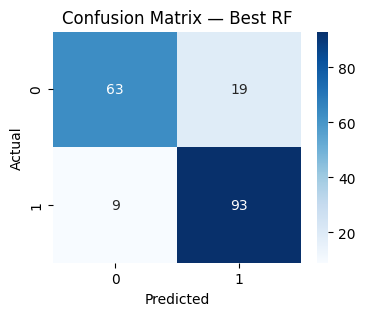

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import joblib

# Fit logistic on full training data for final evaluation
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:,1]

# Best RF is from GridSearch
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

def summarize(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

print("Logistic Regression test metrics:", summarize(y_test, y_pred_lr, y_proba_lr))
print("Random Forest (tuned) test metrics:", summarize(y_test, y_pred_rf, y_proba_rf))

# Confusion matrix visualization for best model
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix — Best RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Theory
We use MLflow to track experiments, parameters, metrics, and artifacts.
This helps reproducibility and comparison across runs.

This cell logs:
- model type
- best params (for RF)
- CV metrics & test metrics
- artifacts: confusion matrix plot, preprocessing pipeline (joblib saved), the cleaned dataset path


2026/01/05 03:08:18 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/05 03:08:19 INFO mlflow.store.db.utils: Updating database tables
2026/01/05 03:08:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/05 03:08:19 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/05 03:08:19 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/05 03:08:19 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/05 03:08:19 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/05 03:08:19 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/05 03:08:19 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/05 03:08:20 INFO alembic.runtime.migration: Running 

Logged LR metrics: {'accuracy': 0.842391304347826, 'precision': 0.8411214953271028, 'recall': 0.8823529411764706, 'roc_auc': 0.9035150645624103}


2026/01/05 03:08:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged RF metrics: {'accuracy': 0.8478260869565217, 'precision': 0.8303571428571429, 'recall': 0.9117647058823529, 'roc_auc': 0.9231229076996652}


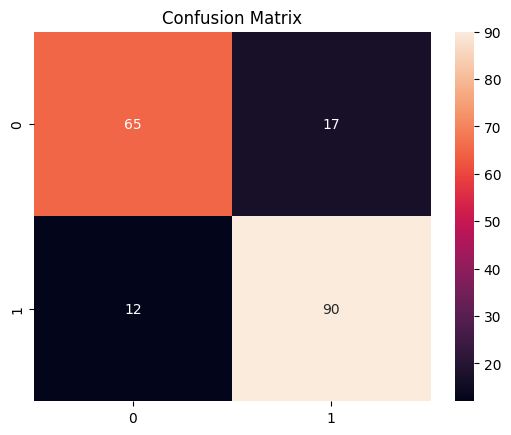

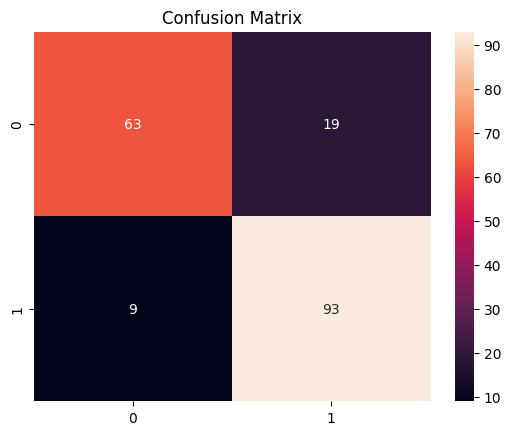

In [13]:
import mlflow, mlflow.sklearn
import json
from datetime import datetime

mlflow.set_experiment("heart_disease_experiment")

def log_run(name, pipeline_obj, X_train, y_train, X_test, y_test, extra_params=None):
    with mlflow.start_run(run_name=name):
        # log params
        params = {"model": pipeline_obj.named_steps['clf'].__class__.__name__}
        if extra_params:
            params.update(extra_params)
        mlflow.log_params(params)
        # Fit
        pipeline_obj.fit(X_train, y_train)
        # Predict
        y_pred = pipeline_obj.predict(X_test)
        y_proba = pipeline_obj.predict_proba(X_test)[:,1]
        # Metrics
        metrics = summarize(y_test, y_pred, y_proba)
        mlflow.log_metrics(metrics)
        # Save model artifact
        mlflow.sklearn.log_model(pipeline_obj, artifact_path="model")
        # Save a small confusion matrix figure
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="d", ax=ax)
        ax.set_title("Confusion Matrix")
        fig_path = f"confusion_{name}.png"
        fig.savefig(fig_path)
        mlflow.log_artifact(fig_path)
        # Log the cleaned dataset path as an artifact (or upload)
        mlflow.log_artifact(clean_path)
        return metrics

# Log LR
lr_metrics = log_run("LogisticRegression_baseline", lr_pipeline, X_train, y_train, X_test, y_test)
print("Logged LR metrics:", lr_metrics)

# Log best RF
rf_metrics = log_run("RandomForest_tuned", best_rf, X_train, y_train, X_test, y_test,
                    extra_params=grid_search.best_params_)
print("Logged RF metrics:", rf_metrics)


### Theory
Save the final model and preprocessing pipeline for serving. We use joblib for a simple approach; MLflow already saved a logged model artifact too.

We also save the preprocessor separately if needed.


In [14]:
# Save using joblib
joblib.dump(best_rf, "best_random_forest_pipeline.joblib")
joblib.dump(lr_pipeline, "logistic_pipeline.joblib")
print("Saved pipelines to disk: best_random_forest_pipeline.joblib, logistic_pipeline.joblib")


Saved pipelines to disk: best_random_forest_pipeline.joblib, logistic_pipeline.joblib


### Theory
Provide a minimal FastAPI app that loads the saved pipeline and exposes `/predict` endpoint.
It accepts JSON feature dict(s) and returns predictions + confidence.

This is the code to be used in the Docker container.


In [15]:
fastapi_app_code = """
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import joblib
import pandas as pd

app = FastAPI(title="Heart Disease Prediction API")

# Define input schema; list of feature dicts
class Patient(BaseModel):
    age: float
    sex: str
    cp: str
    trestbps: float = None
    chol: float = None
    fbs: int = None
    restecg: str = None
    thalch: float = None
    exang: int = None
    oldpeak: float = None
    slope: str = None
    ca: float = None
    thal: str = None

# Load model pipeline
model = joblib.load("best_random_forest_pipeline.joblib")

@app.post("/predict")
def predict(patients: List[Patient]):
    df = pd.DataFrame([p.dict() for p in patients])
    probs = model.predict_proba(df)[:,1]
    preds = model.predict(df)
    return [{"prediction": int(p), "probability": float(prob)} for p, prob in zip(preds, probs)]
"""

with open("app.py", "w") as f:
    f.write(fastapi_app_code.strip())
print("FastAPI app saved to app.py")


FastAPI app saved to app.py


### Theory
Dockerfile to containerize the FastAPI model server. It installs requirements, copies joblib model and app, and runs uvicorn.

Use `docker build -t heart-api:latest .` then `docker run -p 8000:8000 heart-api:latest`.


In [16]:
dockerfile = """
FROM python:3.10-slim

WORKDIR /app
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy model and app
COPY best_random_forest_pipeline.joblib ./best_random_forest_pipeline.joblib
COPY app.py ./app.py

EXPOSE 8000
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]
"""
with open("Dockerfile", "w") as f:
    f.write(dockerfile.strip())
print("Dockerfile created.")


Dockerfile created.


### Theory
A simple Kubernetes Deployment + Service manifest to deploy the container. Replace image with your registry image once pushed.

This manifest exposes the app via ClusterIP Service; for external access use a LoadBalancer or an Ingress (example below uses LoadBalancer).


In [17]:
k8s_manifest = """
apiVersion: apps/v1
kind: Deployment
metadata:
  name: heart-api-deployment
spec:
  replicas: 2
  selector:
    matchLabels:
      app: heart-api
  template:
    metadata:
      labels:
        app: heart-api
    spec:
      containers:
      - name: heart-api
        image: <your-registry>/heart-api:latest
        ports:
        - containerPort: 8000
        resources:
          requests:
            cpu: "250m"
            memory: "256Mi"
          limits:
            cpu: "500m"
            memory: "512Mi"
---
apiVersion: v1
kind: Service
metadata:
  name: heart-api-service
spec:
  type: LoadBalancer
  selector:
    app: heart-api
  ports:
  - port: 80
    targetPort: 8000
"""
with open("k8s_deployment.yaml","w") as f:
    f.write(k8s_manifest.strip())
print("Kubernetes manifest saved to k8s_deployment.yaml")


Kubernetes manifest saved to k8s_deployment.yaml


### Theory
- Logging: Add standard Python logging to the FastAPI app to log request/response and prediction events.
- Monitoring: For containerized apps, expose Prometheus metrics (via middleware) and visualize in Grafana. Here we include a simple Prometheus metrics snippet and show how to enable instrumentation.

We also show simple code to log requests to a file.


In [18]:
monitoring_snippet = """
# For FastAPI, you can add Prometheus metrics using prometheus-client
from prometheus_client import Counter, generate_latest, CONTENT_TYPE_LATEST
REQUEST_COUNT = Counter('request_count', 'App Request Count', ['method','endpoint','http_status'])

# Expose a /metrics endpoint
@app.get("/metrics")
def metrics():
    return Response(generate_latest(), media_type=CONTENT_TYPE_LATEST)
"""
print("Monitoring snippet (add to app.py) printed above for copy-paste.")
print(monitoring_snippet)


Monitoring snippet (add to app.py) printed above for copy-paste.

# For FastAPI, you can add Prometheus metrics using prometheus-client
from prometheus_client import Counter, generate_latest, CONTENT_TYPE_LATEST
REQUEST_COUNT = Counter('request_count', 'App Request Count', ['method','endpoint','http_status'])

# Expose a /metrics endpoint
@app.get("/metrics")
def metrics():
    return Response(generate_latest(), media_type=CONTENT_TYPE_LATEST)



### Theory
Include unit tests for preprocessing and model prediction using pytest. These ensure deterministic behavior in CI.

We create tests:
- test_preprocessing_imputes: verifies imputer fills NaN for a numeric column
- test_predict_api: ensures the API predict function responds with expected keys (we provide a small wrapper function to call the pipeline directly in tests)


In [19]:
# Ensure correct import of Path
from pathlib import Path

# Reset Path in case it was overwritten accidentally
Path = Path

# Create tests directory safely
tests_dir = Path("tests")
tests_dir.mkdir(exist_ok=True)

test_code = """
import pandas as pd
import joblib

model = joblib.load("best_random_forest_pipeline.joblib")

def test_preprocessing_imputes():
    row = {
        "age": 55,
        "sex": "Male",
        "cp": "atypical angina",
        "trestbps": None,
        "chol": None,
        "fbs": None,
        "restecg": None,
        "thalch": None,
        "exang": None,
        "oldpeak": None,
        "slope": None,
        "ca": None,
        "thal": None
    }
    df = pd.DataFrame([row])
    pred = model.predict(df)
    assert len(pred) == 1

def test_predict_output_format():
    row = {
        "age": 60,
        "sex": "Male",
        "cp": "typical angina",
        "trestbps": 140,
        "chol": 239,
        "fbs": 0,
        "restecg": "normal",
        "thalch": 150,
        "exang": 0,
        "oldpeak": 1.0,
        "slope": "upsloping",
        "ca": 0,
        "thal": "normal"
    }
    df = pd.DataFrame([row])
    proba = model.predict_proba(df)[:,1]
    assert len(proba) == 1
"""

# Write the test file
with open(tests_dir / "test_pipeline.py", "w") as f:
    f.write(test_code.strip())

print("Unit tests written to tests/test_pipeline.py")


Unit tests written to tests/test_pipeline.py


### Theory
A GitHub Actions CI pipeline to run linting, tests, and optionally build container. The workflow:
- runs on pushes/PRs
- sets up Python, installs requirements, runs pytest, and runs a simple training script (optional)

Save as `.github/workflows/ci.yml`.


In [20]:
gh_actions = """
name: CI

on:
  push:
    branches: [ main ]
  pull_request:
    branches: [ main ]

jobs:
  test:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: '3.10'
      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt
      - name: Run tests
        run: |
          pytest -q
      - name: Build Docker image
        if: github.ref == 'refs/heads/main'
        run: |
          docker build -t heart-api:ci .
"""
open(".github_workflows_ci.yml","w").write(gh_actions.strip())
print("GitHub Actions workflow template saved to .github_workflows_ci.yml (rename to .github/workflows/ci.yml)")


GitHub Actions workflow template saved to .github_workflows_ci.yml (rename to .github/workflows/ci.yml)


### Final notes & checklist

What we've produced:
- Cleaned dataset saved to `/content/heart_disease_uci_cleaned.csv`.
- Preprocessing pipeline & model training with cross-validation (Logistic Regression & tuned Random Forest).
- MLflow logging for experiments.
- Saved model `best_random_forest_pipeline.joblib` and `logistic_pipeline.joblib`.
- FastAPI app `app.py` for /predict.
- Dockerfile, Kubernetes manifest, unit tests, and GitHub Actions template.
- Monitoring snippet for Prometheus + logging.

How to run locally:
1. Create virtualenv and install requirements: `pip install -r requirements.txt`
2. Run tests: `pytest -q`
3. Start the API locally: `uvicorn app:app --reload --port 8000`
4. Build Docker: `docker build -t heart-api:latest .`
5. Run Docker: `docker run -p 8000:8000 heart-api:latest`
6. To deploy to Kubernetes: replace image in `k8s_deployment.yaml` and `kubectl apply -f k8s_deployment.yaml`.

